# Load Datasets

In [236]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [237]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [238]:
d_path = 'D:\AlbumCover/'
img_dataset_cache = pd.read_csv('./dataset/img.csv')
img_dataset = img_dataset_cache.copy()

In [239]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)
        
#img_arr = img_arr/255.0

In [240]:
img_arr.shape

(1016, 150, 150, 3)

fac

In [241]:
pre_facial = pd.read_csv('./dataset/facial.csv')

if 'Unnamed: 0' in pre_facial.columns:
    pre_facial = pre_facial.drop('Unnamed: 0', axis=1)

In [242]:
imsi = pre_facial.copy()

# categorical data to one-hot
fac_input_df = pd.get_dummies(imsi, prefix=['gender', 'dominant_race'])

# Normalization
fac_input_norm = (fac_input_df - fac_input_df.mean()) / fac_input_df.std()

fac_input = np.array(fac_input_norm)

In [243]:
fac_input.shape

(1016, 16)

clr

In [244]:
clr_data = pd.read_csv('./dataset/clr.csv')
if 'Unnamed: 0' in clr_data.columns:
    clr_data = clr_data.drop('Unnamed: 0', axis=1)

In [245]:
clr_input = np.array( (clr_data - clr_data.mean())/clr_data.std() )

In [246]:
clr_input.shape

(1016, 3)

y

In [247]:
y_data = pd.read_csv('./dataset/y_label.csv')

y_out = np.array(y_data)

img_arr = img_arr.astype('float64')

In [248]:
y_out.shape

(1016, 7)

-----

In [249]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=1234)
fac_input_s = sklearn.utils.shuffle(fac_input, random_state=1234)
clr_input_s = sklearn.utils.shuffle(clr_input, random_state=1234)
y_out_s = sklearn.utils.shuffle(y_out, random_state=1234)

In [250]:
img_arr_test = img_arr_s[900:]
fac_inp_test = fac_input_s[900:]
clr_inp_test = clr_input_s[900:]
y_out_test = y_out_s[900:]

img_arr_s = img_arr_s[:900]
fac_input_s = fac_input_s[:900]
clr_input_s = clr_input_s[:900]
y_out_s = y_out_s[:900]

---

In [251]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                              include_top=False,
                              weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

#pre_trained_model.summary()

In [252]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [253]:
smoothing_param = 0.1
NUM_CLASSES = 7
import keras.backend as K

def smoothed_categorical_crossentropy(y_true, y_pred): 
    if smoothing_param > 0:
        smooth_positives = 1.0 - smoothing_param 
        smooth_negatives = smoothing_param / NUM_CLASSES 
        y_true = y_true * smooth_positives + smooth_negatives 

    return K.categorical_crossentropy(y_true, y_pred)

# class LearningRateSchedule(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         if (epoch+1)%2 == 0:
#             lr = K.get_value(self.model.optimizer.lr)
#             K.set_value(self.model.optimizer.lr, lr*0.94)

In [261]:
from tensorflow.keras.optimizers import RMSprop
from bpmll import bp_mll_loss
import tensorflow_addons as tfa

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(7, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
optimizer = tf.keras.optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9)

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['Precision', 'Recall', tf.compat.v1.losses.log_loss, 'BinaryAccuracy'])

In [262]:
# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [263]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        img_arr_s, y_out_s, 
        batch_size=32, 
        epochs=100, 
        validation_split=0.2, 
        callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)]
    )

Epoch 1/100
23/23 [==============================] - 8s 193ms/step - loss: 1.0556 - precision: 0.2922 - recall: 0.2216 - log_loss: 0.9635 - binary_accuracy: 0.7516 - val_loss: 0.5361 - val_precision: 0.3270 - val_recall: 0.2105 - val_log_loss: 0.5302 - val_binary_accuracy: 0.7603 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 44ms/step - loss: 0.2254 - precision: 0.8358 - recall: 0.6576 - log_loss: 0.2235 - binary_accuracy: 0.9109 - val_loss: 0.5340 - val_precision: 0.3780 - val_recall: 0.1255 - val_log_loss: 0.5293 - val_binary_accuracy: 0.7881 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 44ms/step - loss: 0.0853 - precision: 0.9875 - recall: 0.9139 - log_loss: 0.0847 - binary_accuracy: 0.9815 - val_loss: 0.5416 - val_precision: 0.4685 - val_recall: 0.2105 - val_log_loss: 0.5339 - val_binary_accuracy: 0.7984 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 2s 85ms/step - loss: 0.0349 - precision: 0.9989 - recall: 0.9926 - 

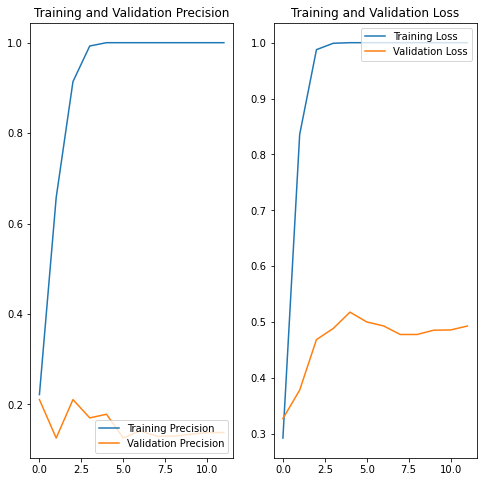

In [265]:
import matplotlib.pyplot as plt

acc = history.history['recall']
val_acc = history.history['val_recall']

loss = history.history['precision']
val_loss = history.history['val_precision']

epochs_range = range(12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [266]:
#model.save('./saved_model/Inception_IMG_binarycross.h5')

In [267]:
model.evaluate(img_arr_test,y_out_test)

4/4 [==============================] - 0s 29ms/step - loss: 0.7699 - precision: 0.5625 - recall: 0.1720 - log_loss: 0.7599 - binary_accuracy: 0.8140


[0.7698696851730347,
 0.5625,
 0.1719745248556137,
 0.7599348425865173,
 0.814039409160614]

In [268]:
2/(1/0.56 + 1/0.16)

0.2488888888888889

In [269]:
k = model.predict(img_arr_test)

In [270]:
k[105]

array([3.4950575e-04, 1.8278152e-02, 6.1214399e-05, 5.8490771e-04,
       3.6146555e-02, 4.6253419e-05, 9.9229038e-02], dtype=float32)

In [271]:
y_out_test[105]

array([0., 0., 1., 0., 0., 0., 0.])

-----

In [272]:
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                              include_top=False,
                              weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [273]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [274]:
from tensorflow.keras.optimizers import RMSprop
from bpmll import bp_mll_loss
import tensorflow_addons as tfa

x = layers.Flatten()(last_output)
real_face_input = tf.keras.layers.Input(shape=(16,))
real_clr_input = tf.keras.layers.Input(shape=(3,))

concat = layers.Concatenate(axis=-1)([x, real_face_input, real_clr_input])

last = layers.Dense(1024, activation='relu')(concat)
last = layers.Dense(7, activation='sigmoid')(last)

model = Model([pre_trained_model.input,real_face_input,real_clr_input], last)
optimizer = tf.keras.optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9)

model.compile(optimizer='adagrad',
            loss='binary_crossentropy',
            metrics=['Precision', 'Recall'])

In [275]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        [img_arr_s,fac_input_s,clr_input_s], 
        y_out_s, 
        batch_size=32, 
        epochs=100, 
        validation_split=0.2, 
        callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)]
    )

Epoch 1/100
23/23 [==============================] - 15s 542ms/step - loss: 0.5211 - precision: 0.2760 - recall: 0.0809 - val_loss: 0.4724 - val_precision: 0.7500 - val_recall: 0.0121 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 7s 337ms/step - loss: 0.4597 - precision: 0.3333 - recall: 0.0042 - val_loss: 0.4637 - val_precision: 0.7500 - val_recall: 0.0121 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 9s 404ms/step - loss: 0.4490 - precision: 0.5000 - recall: 0.0053 - val_loss: 0.4610 - val_precision: 1.0000 - val_recall: 0.0121 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 1s 62ms/step - loss: 0.4416 - precision: 0.6111 - recall: 0.0116 - val_loss: 0.4590 - val_precision: 1.0000 - val_recall: 0.0162 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 1s 66ms/step - loss: 0.4348 - precision: 0.6818 - recall: 0.0158 - val_loss: 0.4578 - val_precision: 1.0000 - val_recall: 0.0121 - lr: 0.0010
Epoch 6/100
23/23 [==

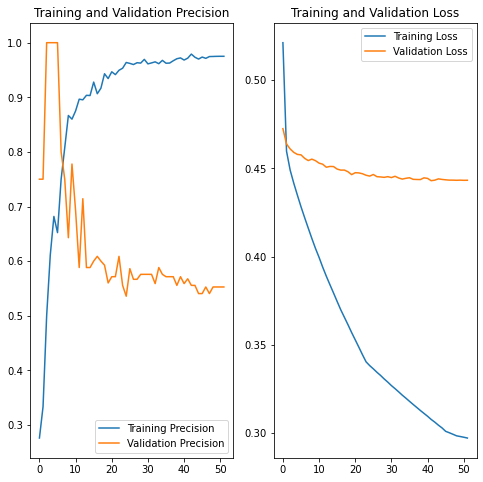

In [276]:
import matplotlib.pyplot as plt

acc = history.history['precision']
val_acc = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(52)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [229]:
model.evaluate([img_arr_test,fac_inp_test,clr_inp_test],y_out_test)

4/4 [==============================] - 0s 27ms/step - loss: 0.4604 - precision: 0.7500 - recall: 0.0573


[0.46039244532585144, 0.75, 0.0573248416185379]

In [233]:
2 / (1/0.75 + 1/0.06) 

0.1111111111111111

In [230]:
model.predict([img_arr_test,fac_inp_test,clr_inp_test])

array([[0.17659947, 0.09730708, 0.30722386, 0.3563398 , 0.14106718,
        0.22376746, 0.18755396],
       [0.06555873, 0.09756739, 0.56000096, 0.08973885, 0.20733723,
        0.33750057, 0.1033695 ],
       [0.07863435, 0.17941667, 0.35013336, 0.07753299, 0.31311125,
        0.17463115, 0.15693344],
       [0.03382535, 0.04548953, 0.36682236, 0.08912361, 0.17449032,
        0.30879506, 0.13697511],
       [0.04895272, 0.1759019 , 0.30524987, 0.04928142, 0.14334144,
        0.25829008, 0.2198094 ],
       [0.14343023, 0.11015575, 0.16015999, 0.09845824, 0.37147215,
        0.3374419 , 0.19620843],
       [0.12224775, 0.12592155, 0.28766352, 0.19609627, 0.2820752 ,
        0.2572726 , 0.22129135],
       [0.08286639, 0.10094949, 0.14308128, 0.05630606, 0.22546479,
        0.31991762, 0.26930344],
       [0.04897437, 0.08030049, 0.34341118, 0.20074742, 0.23323022,
        0.18412344, 0.17358637],
       [0.12877257, 0.10122784, 0.2726769 , 0.1773076 , 0.19021313,
        0.35123655, 0.1

In [231]:
y_out_test[22]

array([0., 0., 0., 0., 1., 1., 0.])

In [50]:
for i in range(7):
    print(len(k[k[i]==1]))

3
14
39
11
25
28
27
